# Running example

In [1]:
import os
import json
import copy
import time
import pickle
import argparse
import warnings
from datetime import datetime
from itertools import product
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Softmax, Lambda, Multiply
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import TimeDistributed
from utils import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel('ERROR')

seed = 3
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

In [2]:
start_time = time.time()

In [3]:
exp_id = 9999
d = 12
k = 8
split_num = 0
items_seed = 0
proxy_lam = 0.5
gamma = 0.5
V_eps = p_eps = rho = 0.0

### Load data

In [4]:
# Items, Users, Prices
# Read data (X, U, p, T, splits)
params_str = ''.join([param_str('gamma', gamma, 0.5),
                      param_str('V_eps', V_eps, 0.0),
                      param_str('p_eps', p_eps, 0.0),
                      param_str('rho', rho, 0.0)
                      ])
filename = f'movielens__items_seed{str(items_seed)}__d{d}{params_str}.pkl'
with open(os.path.join('example_data', filename), 'rb') as f:
    X, all_U, all_p, T, splits = pickle.load(f)

n_markets = all_U.shape[0]
n_splits = len(splits)
m = X.shape[0]      # num items
n = all_U.shape[1]  # num users
d_prime = T.shape[0]  # users features dimension
assert k <= d

In [5]:
train_indices = np.hstack([splits[i] for i in range(n_splits) if i != split_num])
test_indices = splits[split_num]
n_train = len(train_indices)
n_test = len(test_indices)

U_train = all_U[train_indices]
p_train = all_p[train_indices]
U_test = all_U[test_indices]
p_test = all_p[test_indices]

Adjustment for null item (`_ni` stands for null item)

In [6]:
# add the null item
X_ni = np.zeros((X.shape[0] + 1, X.shape[1]))
X_ni[1:] = X

# add price for the null item
p = np.concatenate([p_train, p_test])
p_ni = np.zeros((p.shape[0], p.shape[1] + 1))
p_ni[:, 1:] = p
p_train_ni = p_ni[:n_train, :]
p_test_ni = p_ni[n_train:, :]

### Price-predictive features
Find the $k$ features that are most predictive (predict price from item's features)

Set initial mask distribution $\pi_0$ based on most predictive features.

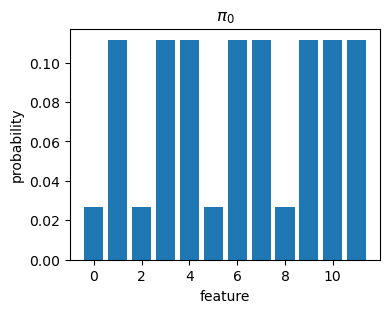

In [7]:
scaler = MinMaxScaler()
n_alphas = 100
alphas, coef_path, _ = lasso_path(scaler.fit_transform(np.concatenate([X]*n_train)), p_train.flatten())

# alphas are in descending order -> (almost) all coefficients starts from 0.0 and 'gets uncovered' later
# feature importance is set by the first non-zero entry
first_non_zero = []
for feature_coefs in coef_path:
    non_zero = np.nonzero(feature_coefs)[0]
    if len(non_zero) == 0:
        first_non_zero.append(n_alphas)
    else:
        first_non_zero.append(non_zero[0])
first_non_zero = np.array(first_non_zero)
features_order_lasso = np.argsort(first_non_zero)

# Set initial mask distributions
# Arbitrarily set the test distribution to a uniform distribution.
pi0 = np.ones(d)
pi0[features_order_lasso[:k]] = 3  
pi0 /= pi0.sum()
pi0_temp = 0.05  # distribution temp
uniform_dist = np.ones(d)

dist_params = {'train': {'scores': pi0, 
                         'T': pi0_temp},
               'test':  {'scores': uniform_dist, 
                         'T': 1}
              }

plt.figure(figsize=(4,3))
plt.bar(range(d), temp_dist(pi0, pi0_temp))

plt.title(r'$\pi_0$')
plt.ylabel('probability')
plt.xlabel('feature')
plt.show()

Generate masks and choices

In [8]:
mu_train, y_train, ipw_train = [], [], []
mu_test, y_test = [], []

for U, p, phase in zip([U_train, U_test], [p_train, p_test], ['train', 'test']):
    for i in range(U.shape[0]):
        # U[i] is a user matrix (n, d') of the i'th market
        # p[i] is a price vector (m) of the i'th market (for a fixed set of items)
        # calculate V
        B = U[i] @ T
        V = B @ X.T
        # draw a mask mu of size k
        mu = sample_mask(**(dist_params[phase]), k=k, m=m)
        # calculate choices of users based on partial information
        Z = X * mu
        V_tilde = B @ Z.T
        y = choice(V_tilde, p[i])
        # change choices so NO_ITEM is item 0
        y = shift_choice(y)
        if phase == 'train':            
            mu_train.append(mu[0])
            y_train.append(y)
        else:
            mu_test.append(mu[0])
            y_test.append(y)

y_train = np.vstack(y_train)
mu_train = np.vstack(mu_train)
y_test = np.vstack(y_test)
mu_test = np.vstack(mu_test)

## Choice Prediction Framework

### Data adjustments 
for prediction model (`_cp` stands for choice prediction)

In [9]:
# flatten the market dimension (prediction is independent of other users)
y_train_cp = y_train.flatten()
y_test_cp = y_test.flatten()
U_train_cp = U_train.reshape((-1, U_train.shape[-1]))
U_test_cp = U_test.reshape((-1, U_test.shape[-1]))

# repeat mask and prices per user (instead of per market) and flatten the market dimension
mu_train_cp = np.repeat(mu_train, n, axis=0).reshape((-1, mu_train.shape[-1]))
mu_test_cp = np.repeat(mu_test, n, axis=0).reshape((-1, mu_test.shape[-1]))
p_train_ni_cp = np.repeat(p_train_ni, n, axis=0).reshape((-1, p_train_ni.shape[-1]))
p_test_ni_cp = np.repeat(p_test_ni, n, axis=0).reshape((-1, p_test_ni.shape[-1]))

### Build model

In [10]:
batch_size = n
inp_p = Input(m+1)           # (batch, m+1)
inp_U = Input(d_prime)       # (batch, d_prime)
inp_mu = Input(d)            # (batch, d)

repeated_mu = K.repeat_elements(tf.expand_dims(inp_mu, 1), rep=m+1, axis=1)              # (batch, m+1, d)
X_batch = K.repeat_elements(tf.Variable([X_ni], dtype=float), rep=batch_size, axis=0)    # (batch, m+1, d)
Z_layer = tf.einsum('bij,bij->bij', X_batch, repeated_mu)                                # (batch, m+1, d)
B_layer = Dense(d, name='T', use_bias=False)(inp_U)                 # (batch, d)
layer = K.batch_dot(B_layer, tf.transpose(Z_layer, perm=[0, 2, 1]))   # (batch, m+1)
layer = layer - inp_p        # (batch, m+1)
temp = 0.0005
layer = Lambda(lambda x: x/temp)(layer)  # temperature layer
out = Softmax()(layer)
choice_prediction_model = Model(inputs=[inp_p, inp_U, inp_mu], outputs=out, name='choice_prediction_model')
layer_T = [layer for layer in choice_prediction_model.layers if layer.name == 'T'][0]

### fit

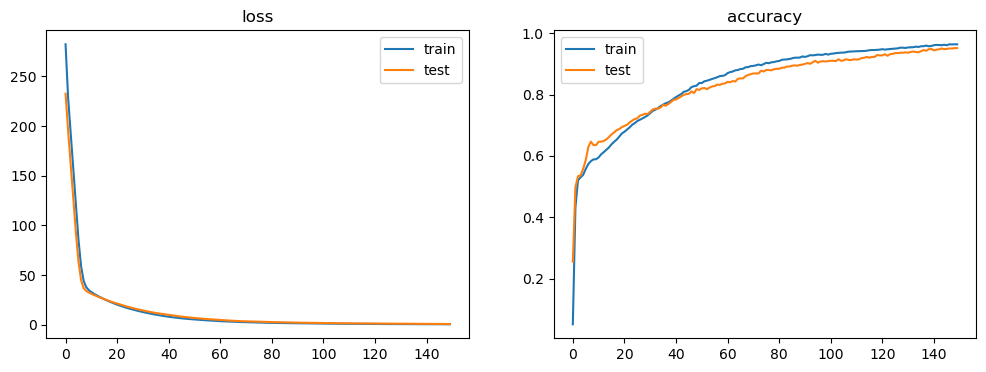

In [11]:
initializer = tf.keras.initializers.GlorotUniform()
layer_T.set_weights([initializer(shape=T.shape)])
epochs = 150
lr = 1e-3
choice_prediction_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                                metrics='accuracy')
history = choice_prediction_model.fit(x=[p_train_ni_cp, U_train_cp, mu_train_cp], y=y_train_cp,
                                      validation_data=([p_test_ni_cp, U_test_cp, mu_test_cp], y_test_cp),
                                      batch_size=batch_size, epochs=epochs, verbose=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, metric in zip(axes, ['loss', 'accuracy']):
    ax.plot(range(epochs), history.history[metric], label='train')
    ax.plot(range(epochs), history.history[f'val_{metric}'], label='test')
    ax.set_title(metric)
    ax.legend()
plt.show()

Define choice-pred based on learned parameters

In [12]:
# choice predictive
choice_predictive_order = (U_train_cp @ layer_T.weights[0].numpy()).mean(axis=0).argsort()[::-1]

## Reference lines

In [13]:
refs = dict()
metrics_dct = {metric: [] for metric in ['welfare', 'congestion', 'unique_items', 'null_items', 'mask', '5masks']}
ref_names = ['random', 'welfare_opt', 'welfare_worst', 'price_predictive', 'choice_predictive',
             'best_learned', 'best_weights_learned']
if d == 100:
    ref_names = [name for name in ref_names if name not in ['welfare_opt', 'welfare_worst']]
refs['train'] = {name: copy.deepcopy(metrics_dct) for name in ref_names}
refs['test'] = copy.deepcopy(refs['train'])
# refs hierarchy: train/test > ref_line > metric

### random

In [14]:
for i in range(100):
    mask = uniform_mask(k, d, m)
    values = calc_all_metrics(X, U_test, T, p_test, mask)
    for metric_name, val in values.items():
        refs['test']['random'][metric_name].append(val)

for metric_name, val_list in refs['test']['random'].items():
        refs['test']['random'][metric_name] = np.mean(val_list)

### optimal (oracle)

In [15]:
if d != 100:
    all_welfare = []
    all_mask = []
    all_congestion = []
    all_null_items = []
    all_unique_items = []

    for comb in product(*[[0, 1] for _ in range(d)]):
        if np.sum(comb) != k:
            continue
        mask = np.array([comb for _ in range(m)])
        values = calc_all_metrics(X, U_test, T, p_test, mask)
        all_welfare.append(values['welfare'])
        all_congestion.append(values['congestion'])
        all_null_items.append(values['null_items'])
        all_unique_items.append(values['unique_items'])
        all_mask.append(comb)

    # ##### welfare-opt
    indx = np.argsort(all_welfare)[:-6:-1]
    refs['test']['welfare_opt']['mask'] = all_mask[indx[0]]
    refs['test']['welfare_opt']['5masks'] = np.mean(np.array(all_mask)[indx], axis=0)
    refs['test']['welfare_opt']['welfare'] = all_welfare[indx[0]]  
    refs['test']['welfare_opt']['congestion'] = all_congestion[indx[0]]  
    refs['test']['welfare_opt']['null_items'] = all_null_items[indx[0]]  
    refs['test']['welfare_opt']['unique_items'] = all_unique_items[indx[0]]  

    # welfare worst
    indx = np.argsort(all_welfare)[:5]
    refs['test']['welfare_worst']['mask'] = all_mask[indx[0]]
    refs['test']['welfare_worst']['5masks'] = np.mean(np.array(all_mask)[indx], axis=0)
    refs['test']['welfare_worst']['welfare'] = all_welfare[indx[0]]
    refs['test']['welfare_worst']['congestion'] = all_congestion[indx[0]]  
    refs['test']['welfare_worst']['null_items'] = all_null_items[indx[0]]  
    refs['test']['welfare_worst']['unique_items'] = all_unique_items[indx[0]]

### predictive

In [16]:
# price-predictive
mask = np.zeros((m, d))
mask[:, features_order_lasso[:k]] = 1
values = calc_all_metrics(X, U_test, T, p_test, mask)
for metric_name, val in values.items():
    refs['test']['price_predictive'][metric_name] = val
price_predictive_mask = np.zeros(d)
price_predictive_mask[features_order_lasso[:k]] = 1
refs['test']['price_predictive']['mask'] = price_predictive_mask

# choice-predictive
mask = np.zeros((m, d))
mask[:, choice_predictive_order[:k]] = 1
values = calc_all_metrics(X, U_test, T, p_test, mask)
for metric_name, val in values.items():
    refs['test']['choice_predictive'][metric_name] = val

choice_predictive_mask = np.zeros(d)
choice_predictive_mask[choice_predictive_order[:k]] = 1
refs['test']['choice_predictive']['mask'] = choice_predictive_mask

## DbR

### Build model

In [17]:
N = 20               
gumbel_temp = 0.2    
softmax_temp = 0.01  
weights_temp = 2

inp_p = Input(m+1)           # (batch, m+1)
inp_U = Input((n, d_prime))  # (batch, n, d_prime)
# sample N different masks
gumbel_layer = GumbelK(dim=d, k=k, t=gumbel_temp, N=N, weights_t=weights_temp, name='gumbel')
gumbel = gumbel_layer(inp_p)  # (N, d)

# apply each mask on an item and obtain N matrices Z (will be applied to all markets)
repeated_mu = K.repeat_elements(tf.expand_dims(gumbel, 1), rep=m+1, axis=1)     # (N, m+1, d)
Z_layer = tf.einsum('ij,nij->nij', X_ni, repeated_mu)                           # (N, m+1, d)
leaned_T_layer = Dense(d, use_bias=False)  # transformation T (already learned): user features -> preferences
leaned_T_layer = TimeDistributed(leaned_T_layer, name='learned_T_dist')
B_hat_layer = leaned_T_layer(inp_U)  # (batch, n, d)
V_hat_layer = tf.einsum('bij,njk->bnik', B_hat_layer, tf.transpose(Z_layer, (0, 2, 1)))  # (batch, N, n, m+1)

layer = V_hat_layer - tf.expand_dims(tf.expand_dims(inp_p, 1), 1)
layer = Lambda(lambda x: x/softmax_temp)(layer)  # temperature layer   # (batch, N, n, m+1)
out = Softmax(axis=-1)(layer)  # (batch, N, n, m+1)
loss_layer = LossLayer(lam=proxy_lam)
out_loss = loss_layer(inp_p, out)

leaned_T_layer.set_weights(layer_T.weights)
leaned_T_layer.trainable = False
model = Model(inputs=[inp_p, inp_U], outputs=out_loss, name='pi_optimization')

### fit

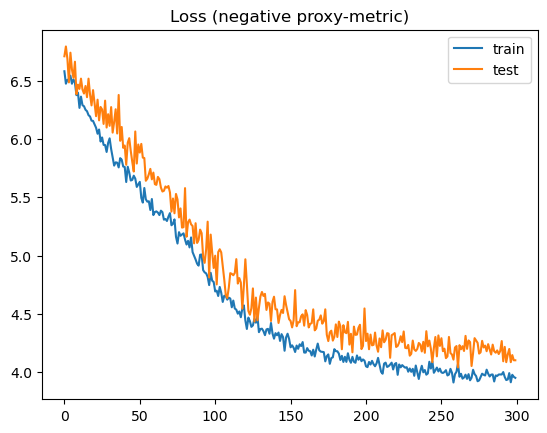

In [18]:
epochs = 300 if k != d else 1
lr = 1e-2

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss=compile_loss)
mask_callback = MasksCallback(model)
acc_callback = AccuracyCallback(model, choice_prediction_model, X, real_T=T, U=U_test, p=p_test, k=k, gumbel_temp=gumbel_temp)
metrics_callback = MetricsCallback(model=model, U=U_test, p=p_test, X=X, real_T=T, k=k)
callbacks = [mask_callback, acc_callback, metrics_callback]

history = model.fit(x=[p_train_ni, U_train], y=[], shuffle=True,
                    validation_data=([p_test_ni, U_test], []),
                    batch_size=batch_size, epochs=epochs, verbose=0,
                    callbacks=callbacks)

plt.figure()
plt.title('Loss (negative proxy-metric)')
plt.plot(range(epochs), history.history['loss'], label='train')
plt.plot(range(epochs), history.history['val_loss'], label='test')
plt.legend()
plt.show()

### variations

#### best learned (loss)

In [19]:
# get loss per mask
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr), 
              loss=compile_loss, run_eagerly=True)
n_skip = len(gumbel_layer.masks)
_ = model.predict([p_test_ni, U_test], batch_size=n_test, verbose=0)
masks = np.array([x.numpy() for x in gumbel_layer.masks[n_skip:]]).squeeze(0)
# get loss per mask by averaging on markets
losses = np.array([x.numpy().mean(axis=0) for x in loss_layer.losses_per_masks[n_skip:]]).squeeze(0)
index = np.argmin(losses)
best_learned_order = masks[index].argsort()[::-1]

# best learned (in terms of loss)
mask = np.zeros((m, d))
mask[:, best_learned_order[:k]] = 1
values = calc_all_metrics(X, U_test, T, p_test, mask)
for metric_name, val in values.items():
    refs['test']['best_learned'][metric_name] = val
best_learned_mask = np.zeros(d)
best_learned_mask[best_learned_order[:k]] = 1
refs['test']['best_learned']['mask'] = best_learned_mask

#### best weights learned

In [20]:
# top-k of the dist params
weights_order = np.array(mask_callback.masks[-1]).squeeze().argsort()[::-1]
if k > (d/2):
    weights_order = weights_order[::-1]
mask = np.zeros((m, d))
mask[:, weights_order[:k]] = 1
values = calc_all_metrics(X, U_test, T, p_test, mask)
for metric_name, val in values.items():
    refs['test']['best_weights_learned'][metric_name] = val
best_weights_learned_mask = np.zeros(d)
best_weights_learned_mask[weights_order[:k]] = 1
refs['test']['best_weights_learned']['mask'] = best_weights_learned_mask

## Results

### metrics

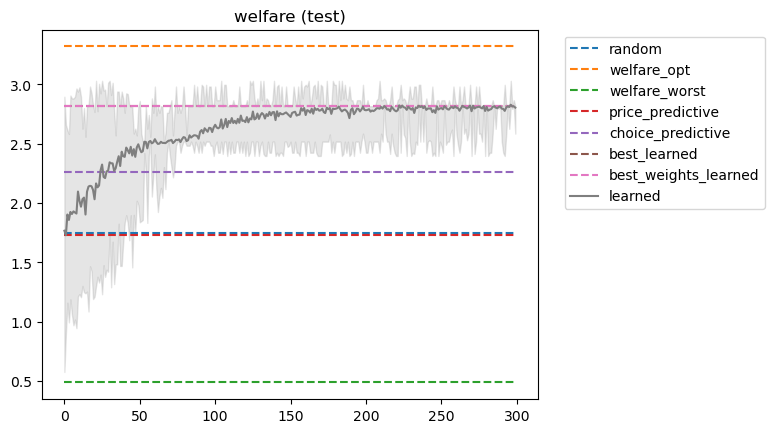

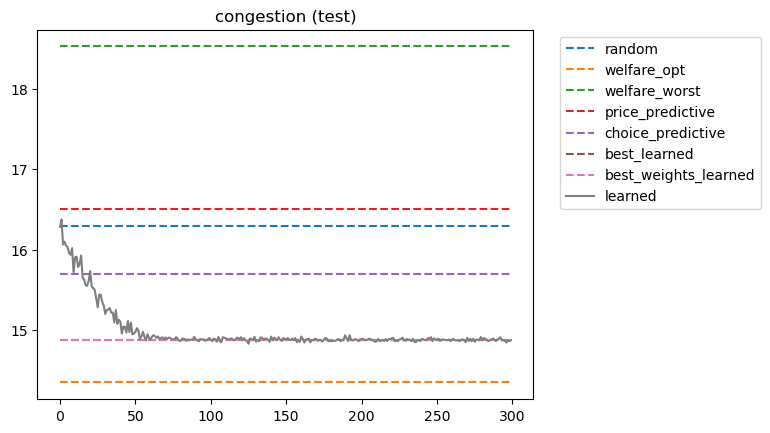

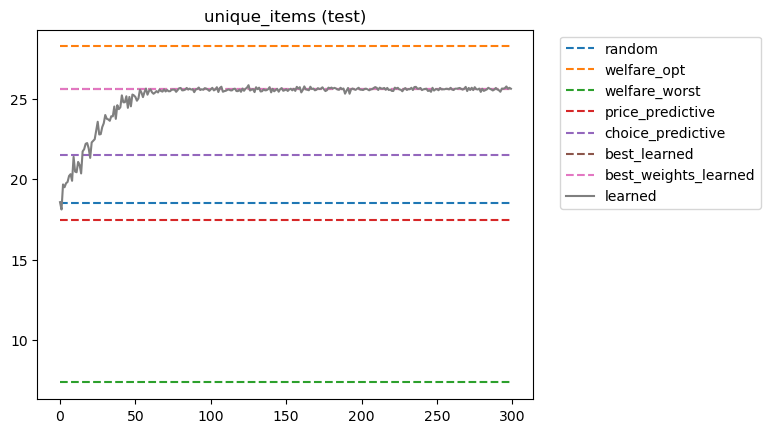

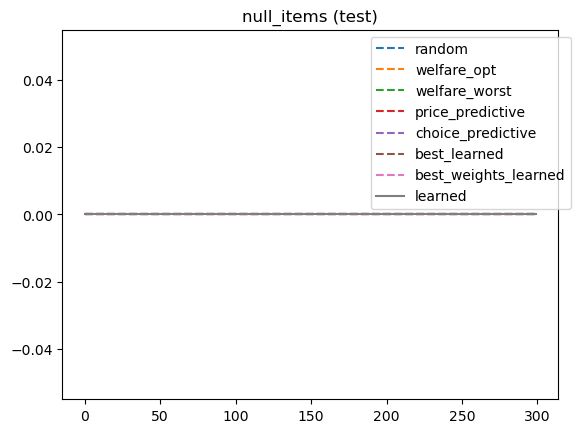

In [21]:
for metric in refs['test']['random'].keys():
    if metric in ['mask', '5masks']:
        continue
    plt.figure()
    plt.title(f'{metric} (test)')
    for name, dct in refs['test'].items():
        val = dct[metric]
        linestyle = 'dashdot' if name == 'proxy_opt' else '--'
        plt.plot(range(epochs), [val]*epochs, linestyle=linestyle, label=name)
    plt.plot(range(epochs), metrics_callback.results[metric], label='learned')
    if metric == 'welfare':
        plt.fill_between(range(epochs), 
                         metrics_callback.results['welfare_q975'],
                         metrics_callback.results['welfare_q025'],
                         color='gray', alpha=0.2)
    plt.legend(bbox_to_anchor=(1.04, 1))
    plt.show()

### prediction accuracy

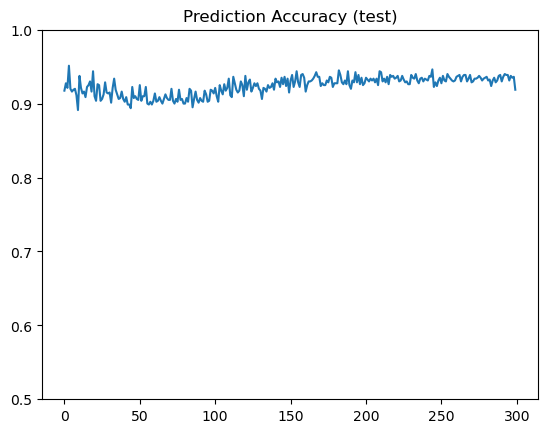

In [22]:
plt.figure()
plt.plot(range(epochs), acc_callback.accuracies)
plt.ylim(0.5, 1)
plt.title('Prediction Accuracy (test)')
plt.show()

In [23]:
time.time() - start_time

463.2434403896332